In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import geemap,ee
import matplotlib.colors as colors
from shapely.geometry import shape, box, Polygon, mapping, Point
from shapely.ops import unary_union
import shapely
from matplotlib import colors
import matplotlib.patches as mpatches
import contextily as ctx
import geemap.colormaps as cm

from sklearn.cluster import DBSCAN, HDBSCAN
import math

In [2]:
ee.Authenticate()

True

In [3]:
ee.Initialize()

## Tomar los datos del IDE

Extraido de https://www.geoportal.cl/geoportal/catalog/35993/Glaciares%20de%20Chile

In [4]:
gdf_glaciares = gpd.read_file('datos/IPG2022_v2.shp')

Cannot find header.dxf (GDAL_DATA is not defined)


In [5]:
gdf_glaciares.crs

<Projected CRS: EPSG:32719>
Name: WGS 84 / UTM zone 19S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 72°W and 66°W, southern hemisphere between 80°S and equator, onshore and offshore. Argentina. Bolivia. Brazil. Chile. Colombia. Peru.
- bounds: (-72.0, -80.0, -66.0, 0.0)
Coordinate Operation:
- name: UTM zone 19S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
gdf_glaciares.to_crs(4326, inplace=True)

In [7]:
gdf_glaciares.head()

,OBJECTID,Id,COD_GLA,NOMBRE,CLASIFICA,AREA_KM2,REGION,PROVINCIA,COMUNA,DATUM,...,WGI_2,WGI_3,FRENTE_TER,RESOL_IMG,ERROR,OBSERVACIO,CUT_REG,CUT_PROV,CUT_COM,geometry
0,174,0,CL101010001@,VOLCAN PARINACOTA,GLACIAR DE MONTAÑA,1.167625,ARICA Y PARINACOTA,PARINACOTA,PUTRE,WGS 84,...,6,3,TIERRA,15.0,0.110762,None,15,152,15201,"POLYGON ((-69.14147 -18.16858, -69.14146 -18.1..."
1,180,0,CL101001023@,VOLCAN POMERAPE,GLACIAR DE MONTAÑA,0.477543,ARICA Y PARINACOTA,PARINACOTA,PUTRE,WGS 84,...,9,6,TIERRA,15.0,0.088744,None,15,152,15201,"POLYGON ((-69.13025 -18.12238, -69.13005 -18.1..."
2,183,0,CL101021004@,S/N,GLACIARETE,0.162167,ARICA Y PARINACOTA,PARINACOTA,PUTRE,WGS 84,...,7,3,TIERRA,15.0,0.052476,None,15,152,15201,"POLYGON ((-69.09348 -18.42529, -69.09408 -18.4..."
3,184,0,CL101021007@,S/N,GLACIARETE,0.093870,ARICA Y PARINACOTA,PARINACOTA,PUTRE,WGS 84,...,9,6,TIERRA,15.0,0.019837,None,15,152,15201,"POLYGON ((-69.08682 -18.42340, -69.08667 -18.4..."
4,185,0,CL101021008@,S/N,GLACIARETE,0.155676,ARICA Y PARINACOTA,PARINACOTA,PUTRE,WGS 84,...,9,6,TIERRA,15.0,0.028012,None,15,152,15201,"POLYGON ((-69.08228 -18.42549, -69.08248 -18.4..."


In [8]:
gdf_glaciares['centroid'] = gdf_glaciares['geometry'].centroid

C:\Users\snmar\AppData\Local\Temp\ipykernel_28560\931950666.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_glaciares['centroid'] = gdf_glaciares['geometry'].centroid


### Calculo de los centroides

In [9]:
transformado = gdf_glaciares['centroid'].to_crs(32719)

In [10]:
coords = transformado.apply(lambda point: (point.x, point.y)).tolist()

### Realizacion de un proceso de clusters, por cercania mediante DBSCAN

In [11]:
epsilon = 800    # Ajusta según sea necesario
min_samples = 2  # Ajusta según sea necesario

db = DBSCAN(eps=epsilon, min_samples=min_samples, metric='euclidean').fit(coords)
gdf_glaciares['cluster'] = db.labels_


In [12]:
gdf_glaciares['cluster'].nunique()

4261

### Filtrado de datos

In [13]:
analisis = gdf_glaciares[(gdf_glaciares['REGION'] == 'ATACAMA') & (gdf_glaciares['NOMBRE'] == 'POTRO NORTE B')].reset_index(drop=True)

In [14]:
gdf_glaciares[(gdf_glaciares['REGION'] == 'ATACAMA')].NOMBRE.unique()

array(['S/N', 'MONGOTES', 'CASERONES', 'CANTARITOS', 'CANTARITOS 3',
       'CANTARITOS 2', 'CANTARITOS 4', 'RIO GRANDE', 'ESTERO SECO B',
       'TRONQUITOS OESTE', 'TRONQUITOS A', 'COLORADO', 'MARANCELES',
       'POTRO NORTE A', 'JOTABECHE 4', 'JOTABECHE 1', 'LOS CUYANOS A',
       'LOS CUYANOS B', 'ESTERO SECO A', 'JOTABECHE 2 B', 'JOTABECHE 2 A',
       'CANTARITOS 1', 'LOS CUYANOS SUR A', 'JOTABECHE 2 C',
       'TRONQUITOS B', 'LOS CUYANOS SUR B', 'ESTRECHO A', 'ORTIGAS 1',
       'ORTIGAS 2', 'ESTRECHO B', 'TORO 2 SUPERIOR', 'TORO 2 INFERIOR',
       'DEL POTRO', 'JOTABECHE 5', 'GUANACO', 'AMARILLO',
       'MARANCELES ESTE', 'JOTABECHE 3', 'POTRO NORTE B', 'POTRO NORTE C'],
      dtype=object)

In [15]:
analisis.head()

,OBJECTID,Id,COD_GLA,NOMBRE,CLASIFICA,AREA_KM2,REGION,PROVINCIA,COMUNA,DATUM,...,FRENTE_TER,RESOL_IMG,ERROR,OBSERVACIO,CUT_REG,CUT_PROV,CUT_COM,geometry,centroid,cluster
0,1425,0,CL103412017B,POTRO NORTE B,GLACIARETE,0.015169,ATACAMA,COPIAPO,TIERRA AMARILLA,WGS 84,...,TIERRA,10.0,0.005084,None,03,031,03103,"POLYGON ((-69.60805 -28.36016, -69.60806 -28.3...",POINT (-69.60835 -28.35960),153


In [16]:
seleccionado = 153

In [17]:
filtro = gdf_glaciares[gdf_glaciares['cluster'] == seleccionado]

<Axes: >

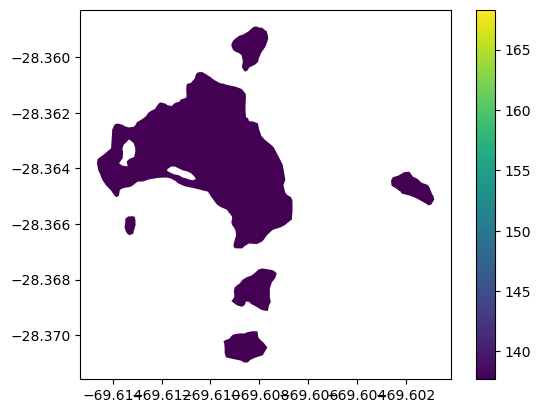

In [18]:
filtro.plot(column='cluster', legend=True)

In [19]:
analisis.columns

Index(['OBJECTID', 'Id', 'COD_GLA', 'NOMBRE', 'CLASIFICA', 'AREA_KM2',
       'REGION', 'PROVINCIA', 'COMUNA', 'DATUM', 'HUSO', 'NORTE', 'ESTE',
       'FUENTE_DIG', 'FUEN_FECHA', 'INVE_FECHA', 'NOM_CUEN', 'COD_CUEN',
       'COD_SCUEN', 'COD_SSCUEN', 'MZON_GLAC', 'CH_CASQ', 'CUBIERTO',
       'LATITUD', 'LONGITUD', 'PERIMETRO', 'ORIENTA', 'HMEDIA', 'HMAX', 'HMIN',
       'PENDIENTE', 'ESP_MED', 'F_ESP_MED', 'VOL_km3', 'EQ_AGUAKM3', 'WGI_1',
       'WGI_2', 'WGI_3', 'FRENTE_TER', 'RESOL_IMG', 'ERROR', 'OBSERVACIO',
       'CUT_REG', 'CUT_PROV', 'CUT_COM', 'geometry', 'centroid', 'cluster'],
      dtype='object')

### Obtener AOI e imagenes 

In [20]:
big_glaciar = unary_union(gdf_glaciares[gdf_glaciares['cluster'] == seleccionado].geometry)

In [21]:
x, y = big_glaciar.centroid.xy

In [22]:
def getAOI_latlon(dat):
    aoi = ee.Geometry.Polygon(dat)
    return(aoi)

In [23]:
def shapely_to_ee_geometry(shapely_geom):
    coords = list(shapely_geom.exterior.coords)
    ee_geom = ee.Geometry.Polygon(coords)
    return ee_geom

# Convertir cada polígono en el MultiPolygon a una geometría de EE
ee_geometries = [shapely_to_ee_geometry(poly) for poly in big_glaciar.geoms]

# Crear una geometría de EE MultiPolygon
ee_multipolygon = ee.Geometry.MultiPolygon(ee_geometries)

In [24]:
big_glaciar = big_glaciar.convex_hull

### Area de acotamiento

In [25]:
def getAOI_latlon(dat):
    aoi = ee.Geometry.Polygon(dat)
    return(aoi)
    

In [26]:
aoi = getAOI_latlon(mapping(big_glaciar.boundary)['coordinates'])

In [27]:
extract = [f"{str(a)}-01-01" for a in range(2013, 2025)]

### Determinar un area para visualizar el glaciar y no tener toda la imagen

In [28]:
aoi_glaciar = aoi.buffer(1500)

### Estimacion de area de glaciar

In [29]:
# Función para convertir los valores DN a reflectancia TOA
def calculate_toa_reflectance(image, image_f):
   
    toa_image = image.expression(
        '((ML * Qcal) + AL) / sin(theta_se)', {
            'ML': ee.Image.constant(0.00002),  # factor de reescalado multiplicativo (ejemplo)
            'Qcal': image,
            'AL': ee.Image.constant(-0.1),  # factor de reescalado aditivo (ejemplo)
            'theta_se': ee.Number(image_f.get('SUN_ELEVATION')) #calculate_solar_elevation_angle(image)  # ángulo de elevación del sol en radianes (ejemplo)
        })
    return toa_image

# Función para calcular la temperatura de brillo en el satélite
def calculate_brightness_temperature(image):
    brightness_temp = image.expression(
        'K2 / log((K1 / (((ML * Qcal) + AL) - const)) + 1)', {
            'K1': ee.Image.constant(774.89),  # constante de conversión térmica (ejemplo)
            'K2': ee.Image.constant(1321.08),  # constante de conversión térmica (ejemplo)
            'ML': ee.Image.constant(0.00002),  # factor de reescalado multiplicativo (ejemplo)
            'Qcal': image,
            'AL': ee.Image.constant(-0.1), 
            'const': ee.Image.constant(0.29),
        })
    return brightness_temp

# Función para calcular el NDSI con un threshold de 0.
def calculate_ndsi(image):
    green = image.select('B3')  # banda verde

    condition_b6 = image.select('B6').lte(0.11)
    swir = image.select('B6')  # banda SWIR
    filtered_b6 = swir.updateMask(condition_b6)
    ndsi = green.subtract(filtered_b6).divide(green.add(filtered_b6)).rename('NDSI')
    return image.addBands(ndsi)

# Definir la función para calcular el NDVI
def calculate_ndvi(image):
    nir = image.select('B5')  # banda NIR
    red = image.select('B4')  # banda roja
    ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')
    return image.addBands(ndvi)

def calculate_ndgi(image):
    swir = image.select('B6')
    green = image.select('B3')  
    ndgi = green.subtract(swir).divide(green.add(swir)).rename('NDGI')
    return image.addBands(ndgi)
    
def calculate_ndwi(image):
    green = image.select('B3') 

    condition_b5 = image.select('B5').lt(0.2)
    
    swir1 = image.select('B5')  
    filtered_b5 = swir1.updateMask(condition_b5)
    
    ndwi = green.subtract(filtered_b5).divide(green.add(filtered_b5)).rename('NDWI')
    return image.addBands(ndwi)

def calculate_ndsi_pure(image):
    green = image.select('B3')  # banda verde

    swir = image.select('B6')  # banda SWIR
    ndsi = green.subtract(swir).divide(green.add(swir)).rename('NDSI')
    return image.addBands(ndsi)

def calculate_ndwi_pure(image):
    green = image.select('B3') 
    swir1 = image.select('B5')  
    ndwi = green.subtract(swir1).divide(green.add(swir1)).rename('NDWI')
    return image.addBands(ndwi)

def add_band_B8_B6(image):
    diferencepan = image.normalizedDifference(['B8', 'B6']).rename('B8/B6')
    return image.addBands(diferencepan)

In [30]:
def extract_images_for_year_landsatT1(extract, aoi_glaciar):

    
    dataset_dict = {}
    
    for pos in range(len(extract) - 1):
        dataset = ee.ImageCollection("LANDSAT/LC08/C02/T1").filterDate(extract[pos], extract[pos + 1]).filter(ee.Filter.lt('CLOUD_COVER', 10)).filterBounds(aoi_glaciar)
        dataset = dataset.map(calculate_ndsi_pure)
        dataset = dataset.map(calculate_ndvi)
        dataset = dataset.map(calculate_ndwi_pure)
        dataset = dataset.map(add_band_B8_B6)
        
        
        dataset_dict[extract[pos][:4]] = dataset
 
    return dataset_dict

def make_visual(collection_years, aoi_glaciar, extract):

    views_dict = {}

    for pos in range(len(extract) - 1):
        views = []

        collection = collection_years[extract[pos][:4]]

        image_f = collection.first().clip(aoi_glaciar)
        
        image = collection.median().clip(aoi_glaciar)

        toa_reflectance = calculate_toa_reflectance(image, image_f)
        brightness_temp = calculate_brightness_temperature(image)
        image_with_ndsi = calculate_ndsi(toa_reflectance)
        image_with_ndvi = calculate_ndvi(image_with_ndsi)
        image_with_ndgi = calculate_ndgi(toa_reflectance)
        image_with_ndwi = calculate_ndwi(toa_reflectance)

        views.append(toa_reflectance)
        views.append(brightness_temp)
        views.append(image_with_ndsi)
        views.append(image_with_ndvi)
        views.append(image_with_ndgi)
        views.append(image_with_ndwi)
        
        views_dict[extract[pos][:4]] = views

    return views_dict
    
    
    

In [31]:
collection_years = extract_images_for_year_landsatT1(extract, aoi_glaciar)
visual = make_visual(collection_years, aoi_glaciar, extract)


In [32]:
def calculate_ndpan(collection_years):
    views_dict = {}

    for pos in range(len(extract) - 1):
        views = []

        collection = collection_years[extract[pos][:4]]

        image = collection.median().clip(aoi_glaciar)

        
        diferencepan = image.normalizedDifference(['B8', 'B6']).rename('glacierPAN')
        diferencered = image.normalizedDifference(['B4', 'B6']).rename('glacierRED')

        mask = diferencepan.gte(0.4)

        
        views.append(diferencepan)
        views.append(diferencered)

        diferencered_filter = diferencepan.updateMask(mask)
        
        views.append(diferencered_filter)
        
        views_dict[extract[pos][:4]] = views

    return views_dict
    
    

In [33]:
area_visual = calculate_ndpan(collection_years)

In [34]:
Map = geemap.Map(center=[y[0], x[0]], zoom=12)

# Iterar sobre las llaves del diccionario y agregar la primera imagen de cada lista al mapa
for year, image_list in area_visual.items():
    first_image = image_list[0]
    second_image = image_list[1]
    third_image = image_list[2]
    
    # Map.addLayer(first_image, {'bands': ['glacierPAN'], 'min': 0, 'max': 1, 'palette': ['blue', 'white', 'green']}, f'{year} PAN Image')
    # Map.addLayer(second_image, {'bands': ['glacierRED'], 'min': 0, 'max': 1, 'palette': ['blue', 'white', 'green']}, f'{year} RED Image')
    Map.addLayer(third_image, {'bands': ['glacierPAN'], 'min': 0.4, 'max': 1, 'palette': ['blue', 'white', 'green']}, f'{year} PAN_threshold Image')
    # Map.addLayer(visual[year][1], {}, f'{year} Brightness Image')


Map.add_layer(ee_multipolygon, {}, 'glaciar')
Map

Map(center=[-28.364056553147115, -69.6095871859815], controls=(WidgetControl(options=['position', 'transparent…

### Vectorizacion de la imagen que más acierta al area del glaciar dado por la inforcion vectoria del IDE

In [35]:
glacier_area = area_visual['2019'][0].expression(
  'panglacier * const', {
    'panglacier': area_visual['2019'][0].select('glacierPAN'),
    'const': 1000 
  }).rename('glacierPANINT').toInt();

In [36]:
vectors = glacier_area.reduceToVectors(
  geometry= aoi_glaciar,
  scale=30,
  geometryType= 'polygon',
  eightConnected= False,
  bestEffort = True,
  labelProperty= 'B8/B6',
  maxPixels = 1e8,
);

In [37]:
PanMin = ee.Number(glacier_area.reduceRegion(
  reducer  = ee.Reducer.min(),
  geometry  = aoi_glaciar,
  scale     = 15,
  maxPixels = 1e9
).values().get(0));

# // Calculate the maximum LST value within the AOI
PanMax = ee.Number(glacier_area.reduceRegion(
  reducer  = ee.Reducer.max(),
  geometry = aoi_glaciar,
  scale    = 15,
  maxPixels = 1e9
).values().get(0));

In [38]:
Map.addLayer(vectors, {'min': PanMin.getInfo(), #// Minimum LST value
  'max': PanMax.getInfo(), #// Maximum LST value
    }, 'vectors')

In [39]:
Map

Map(center=[-28.364056553147115, -69.6095871859815], controls=(WidgetControl(options=['position', 'transparent…

### Transformación de la capa de vectores a aun gdf

In [40]:
value = geemap.ee_to_gdf(vectors)
value.head()

,geometry,B8/B6,count
0,"POLYGON ((-69.58566 -28.36511, -69.58539 -28.3...",-73,1
1,"POLYGON ((-69.58566 -28.36565, -69.58539 -28.3...",-130,1
2,"POLYGON ((-69.58593 -28.36323, -69.58566 -28.3...",17,1
3,"POLYGON ((-69.58593 -28.36350, -69.58566 -28.3...",25,1
4,"POLYGON ((-69.58593 -28.36377, -69.58566 -28.3...",37,1


### Clasificacion de aquellos valores donde el Panchromatic dividido por el SWIR fuera mayor a 0.4, en este caso mayor a 400, pues se multiplico por 1000 al transformar la banda 'vectors', esto debido a que es necesario a que sea un Integer y no un Float

In [41]:
value['glaciar'] = value['B8/B6'].apply(lambda x: 1 if x >= 400 else 0)

In [42]:
value[value['glaciar'] == 0].count()

geometry    13660
B8/B6       13660
count       13660
glaciar     13660
dtype: int64

### Dada la limitacion de 5000 elementos para tranformar en elementos en geemap, lo que hicimos fue particionar el gdf de value, en bloques de 4000 elementos cada uno

In [43]:
chunk_size = 4000

# Lista para guardar los fragmentos
fragments = []

# Iterar a través del DataFrame en incrementos de 4000
for start in range(0, len(value), chunk_size):
    fragment = value[start:start + chunk_size]
    fragments.append(fragment)

In [44]:
def gdf_to_ee(gdf):
    def feature_to_ee(feature):
        geom = ee.Geometry(mapping(feature['geometry']))
        properties = feature.drop('geometry').to_dict()
        return ee.Feature(geom, properties)
    
    ee_features = gdf.apply(feature_to_ee, axis=1).tolist()
    return ee.FeatureCollection(ee_features)

In [45]:
polygon_ee_fragments = []

for fragment in fragments:
    polygon_ee = geemap.gdf_to_ee(fragment)
    polygon_ee_fragments.append(polygon_ee)

### Funcion que se encarga de calcular la Media y Desviacion Estandar de los pixeles en las imagenes

In [46]:
def calculate_mean_stddev_variance(image, polygons):
    if not image or not polygons:
        raise ValueError("La imagen y los polígonos no deben ser nulos")

    def calculate_stats_for_polygon(polygon):
        stats = image.reduceRegion(
            reducer=ee.Reducer.mean()
                .combine(reducer2=ee.Reducer.stdDev(), sharedInputs=True), 
            geometry=polygon.geometry(),
            scale=30,  
            crs='EPSG:4326'
        )
        return polygon.set(stats)

    stats = polygons.map(calculate_stats_for_polygon)

    return stats

### Calculamos los datos de la Media y la Desviacion Estandar

In [47]:
mean_values_frag = []

for poligon_frag in polygon_ee_fragments:
    mean_values = calculate_mean_stddev_variance(collection_years['2019'].median().clip(aoi_glaciar), poligon_frag)
    mean_values_frag.append(mean_values)

In [48]:
# Extraido de ChatGPT y editado para el codigo

def ee_feature_collection_to_geodataframe(fc):
    fc_dict = fc.getInfo()
    
    features = fc_dict['features']
    
    geometries = []
    properties = []

    for feature in features:
        geom = shape(feature['geometry'])  # Convierte la geometría a un objeto Shapely
        geometries.append(geom)  # Añade la geometría a la lista
        props = feature['properties']  # Obtén las propiedades
        properties.append(props)  # Añade las propiedades a la lista

    df = pd.DataFrame(properties)

    gdf = gpd.GeoDataFrame(df, geometry=geometries)

    return gdf

### Transformamos cada fragmento con la Media y Desviacion Estandar a un gdf

In [49]:
gdf_train_sections = []

for mean_frag in mean_values_frag:
    gdf_training = ee_feature_collection_to_geodataframe(mean_frag)
    gdf_train_sections.append(gdf_training)


### Concatenamos todas los gdf en uno solo

In [50]:
gdf_training = pd.concat(gdf_train_sections, ignore_index=True)

### Guardamos los datos a un GeoJSON

In [51]:
gdf_training.to_file('training_glaciar.geojson', driver='GeoJSON')

### Seleccion de aquellas columnas usadas para el entrenamiento del modelo de clasificación

In [52]:
gdf_training.columns

Index(['B10_mean', 'B10_stdDev', 'B11_mean', 'B11_stdDev', 'B1_mean',
       'B1_stdDev', 'B2_mean', 'B2_stdDev', 'B3_mean', 'B3_stdDev', 'B4_mean',
       'B4_stdDev', 'B5_mean', 'B5_stdDev', 'B6_mean', 'B6_stdDev', 'B7_mean',
       'B7_stdDev', 'B8/B6', 'B8/B6_mean', 'B8/B6_stdDev', 'B8_mean',
       'B8_stdDev', 'B9_mean', 'B9_stdDev', 'NDSI_mean', 'NDSI_stdDev',
       'NDVI_mean', 'NDVI_stdDev', 'NDWI_mean', 'NDWI_stdDev', 'QA_PIXEL_mean',
       'QA_PIXEL_stdDev', 'QA_RADSAT_mean', 'QA_RADSAT_stdDev', 'SAA_mean',
       'SAA_stdDev', 'SZA_mean', 'SZA_stdDev', 'VAA_mean', 'VAA_stdDev',
       'VZA_mean', 'VZA_stdDev', 'count', 'glaciar', 'geometry'],
      dtype='object')

In [53]:
columns_to_use = ['B10_mean', 'B10_stdDev', 'B11_mean', 'B11_stdDev', 'B1_mean',
       'B1_stdDev', 'B2_mean', 'B2_stdDev', 'B3_mean', 'B3_stdDev', 'B4_mean',
       'B4_stdDev', 'B5_mean', 'B5_stdDev', 'B6_mean', 'B6_stdDev', 'B7_mean',
       'B7_stdDev', 'B8_mean', 'B8_stdDev', 'B9_mean', 'B9_stdDev', 'B8/B6_mean', 'B8/B6_stdDev' ,'NDSI_mean', 'NDSI_stdDev', 'NDVI_mean', 'NDVI_stdDev']

## Modelo de Clasificacion

In [54]:
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, roc_auc_score, roc_curve, recall_score
import joblib


### Separamos los datos para el modelo y los datos de clasificacion

In [55]:
y_class = gdf_training['glaciar'] # Datos Binarios, 0 indica que no hay glaciar y 1 que si hay glaciar
X = gdf_training[columns_to_use]

#### Se realiza una estandarizacion de los datos

In [56]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(X)

In [57]:
X = pd.DataFrame(df_scaled, columns=X.columns)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size = 0.2, stratify=y_class)

### Se buscan los mejores parametros tales que nos entregue el mejor accuracy el modelo

In [59]:
rf = RandomForestClassifier()

# Definir los hiperparámetros a buscar en GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20, 30],
    'min_samples_leaf': [1, 2, 4, 6, 7],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid_search.best_params_)

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits
Mejores hiperparámetros: {'bootstrap': True, 'max_depth': 50, 'min_samples_leaf': 7, 'min_samples_split': 20, 'n_estimators': 100}


In [60]:
params = grid_search.best_params_
params

{'bootstrap': True,
 'max_depth': 50,
 'min_samples_leaf': 7,
 'min_samples_split': 20,
 'n_estimators': 100}

### Definicion del clasificador con los mejores parametros encontrados

In [61]:
clasificador = RandomForestClassifier(max_depth=params['max_depth'], min_samples_leaf=params['min_samples_leaf'], 
                                      min_samples_split=params['min_samples_split'], n_estimators=params['n_estimators'], bootstrap=params['bootstrap'])

In [62]:
clasificador.fit(X_train, y_train)

RandomForestClassifier(max_depth=50, min_samples_leaf=7, min_samples_split=20)

In [63]:
y_pred = clasificador.predict(X_test)
y_pred_prob = clasificador.predict_proba(X_test)[:, 1]

In [64]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Recall Score: {recall:.4f}')
print(f'ROC AUC Score: {roc_auc:.4f}')

Accuracy: 0.9970
F1 Score: 0.9921
Recall Score: 0.9890
ROC AUC Score: 1.0000


### Curva ROC

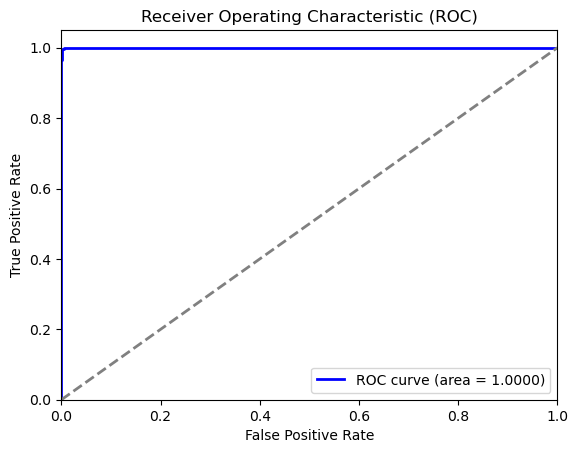

In [65]:
# Extraido de ChatGPT

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

### Matriz de confunsion

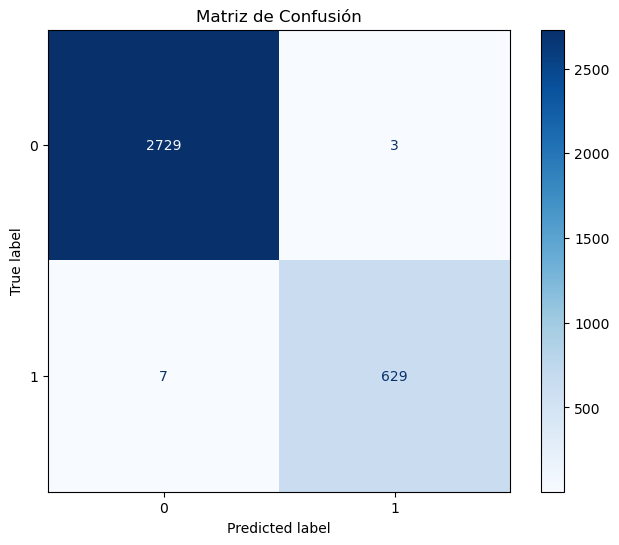

In [66]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Matriz de Confusión')
plt.show()

### Guardamos el modelo

In [67]:
# Guardar el clasificador en un archivo
joblib_file = "random_forest_model.pkl"  
joblib.dump(clasificador, joblib_file)

['random_forest_model.pkl']

### Espacio de Clasificacion

In [68]:
testing_locations = {
    '1': (-18.17448, -69.14340),
    '2': (-34.81807, -70.33225),
    '3': (-18.42484, -69.08139),
    '4': (-28.35960, -69.60835)
}

### Creamos los bordes del area de clasificacion

In [69]:
margin = 0.05

rectangles = {}
for key, (lon, lat) in testing_locations.items():
    rect_coords = [
        (lat - margin, lon - margin),
        (lat - margin, lon + margin),
        (lat + margin, lon + margin),
        (lat + margin, lon - margin),
        (lat - margin, lon - margin) 
    ]
    rectangles[key] = rect_coords

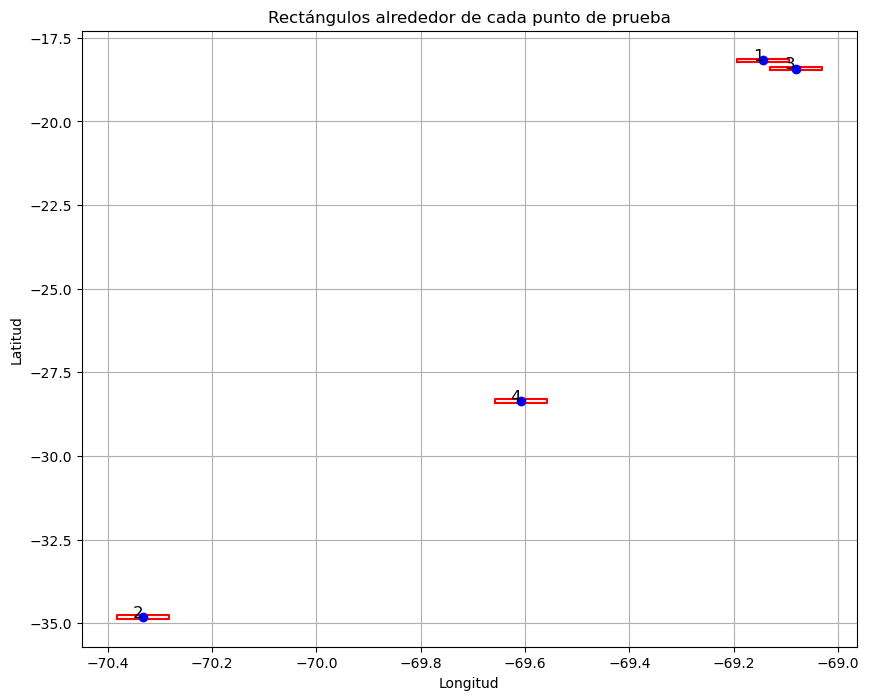

In [70]:
plt.figure(figsize=(10, 8))

for key, rect_coords in rectangles.items():
    plt.plot(*zip(*rect_coords), linestyle='-', color='r', label=f'Rectángulo {key}' if key == '1' else "")

for key, (lat, lon) in testing_locations.items():
    plt.plot(lon, lat, 'bo')  # Puntos azules
    plt.text(lon, lat, key, fontsize=12, ha='right')

plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Rectángulos alrededor de cada punto de prueba')
plt.grid(True)
plt.show()

### Transformamos los rectangulos a un Polygon de ee

In [71]:
values_position = [ee.Geometry.Polygon(a) for a in rectangles.values()]

In [72]:
visualization = {
    'min': 0.0,
    'max': 65000,
    'bands': ['B4', 'B3', 'B2'],
}

In [73]:
pos = '2'

In [74]:
data_verano = [(f'{a}-12-01', f'{a+1}-04-30') for a in range(2013, 2024)]

### Funciones para extraer las collections de las fechas de verano desde el 2013 hasta el 2024

In [75]:
def extract_images_for_year_landsatT1_verano(extract, aoi_glaciar):

    dataset_dict = {}
    
    for pos in range(len(extract)):
        dataset = ee.ImageCollection("LANDSAT/LC08/C02/T1").filterDate(extract[pos][0], extract[pos][1]).filter(ee.Filter.lt('CLOUD_COVER', 10)).filterBounds(aoi_glaciar)
        dataset = dataset.map(calculate_ndsi_pure)
        dataset = dataset.map(calculate_ndvi)
        dataset = dataset.map(calculate_ndwi_pure)
        dataset = dataset.map(add_band_B8_B6)
        
        
        dataset_dict[extract[pos][1][:4]] = dataset
 
    return dataset_dict

def make_visual_verano(collection_years, aoi_glaciar, extract):

    views_dict = {}

    for pos in range(len(extract)):
        views = []

        collection = collection_years[extract[pos][1][:4]]

        image_f = collection.first().clip(aoi_glaciar)
        
        image = collection.median().clip(aoi_glaciar)

        toa_reflectance = calculate_toa_reflectance(image, image_f)
        brightness_temp = calculate_brightness_temperature(image)
        image_with_ndsi = calculate_ndsi(toa_reflectance)
        image_with_ndvi = calculate_ndvi(image_with_ndsi)
        image_with_ndgi = calculate_ndgi(toa_reflectance)
        image_with_ndwi = calculate_ndwi(toa_reflectance)

        views.append(toa_reflectance)
        views.append(brightness_temp)
        views.append(image_with_ndsi)
        views.append(image_with_ndvi)
        views.append(image_with_ndgi)
        views.append(image_with_ndwi)
        
        
        views_dict[extract[pos][1][:4]] = views

    return views_dict
    

In [76]:
test_collection = {}
test_visuals = {}

for value in range(len(values_position)):
    test_collection[value] = extract_images_for_year_landsatT1_verano(data_verano, values_position[value])
    test_visuals[value] = make_visual_verano(test_collection[value], values_position[value], data_verano)


In [77]:
m2 = geemap.Map()
m2.set_center(testing_locations[pos][1], testing_locations[pos][0], 12)
m2.add_layer(test_collection[1]['2019'].median().clip(values_position[1]), visualization, 'TrueColor')
m2

Map(center=[-34.81807, -70.33225], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sear…

### Calculo de las bandas extras

In [78]:
for value in range(len(values_position)):
    for year in data_verano:
        year = year[1]
        if year[:4] == '2024':
            continue
        else:
            test_collection[value][year[:4]] = test_collection[value][year[:4]].map(add_band_B8_B6)
            test_collection[value][year[:4]] = test_collection[value][year[:4]].map(calculate_ndsi_pure)
            test_collection[value][year[:4]] = test_collection[value][year[:4]].map(calculate_ndvi)
            test_collection[value][year[:4]] = test_collection[value][year[:4]].map(calculate_ndwi_pure)

### Clipeamos las medias de las colecciones de imagenes a nuestro rectangulo de observacion y se le filtran las bandas, dejando solo aquellas que se usaran

In [79]:
clipped_images = {}

for value in range(len(values_position)):
    clipped_images[f'{value}'] = {} 
    for year in data_verano:
        year = year[1]
        if year[:4] == '2024':
            continue
        else:
            cliped_image = test_collection[value][year[:4]].median().clip(values_position[value]).select('B1', 'B10', 'B11', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B8/B6', 'NDSI', 'NDVI'),  
            clipped_images[f'{value}'][year[:4]] = cliped_image

### Aplicacion del algoritmo SNIC

In [80]:
clipped_image_snic = {}

for value in range(len(values_position)):
    clipped_image_snic[f'{value}'] = {} 
    for year in data_verano:
        year = year[1]
        if year[:4] == '2024':
            continue
        else:
            snic = ee.Algorithms.Image.Segmentation.SNIC(image=clipped_images[f'{value}'][year[:4]],size=30,compactness=0.1,connectivity=4);
            clipped_image_snic[f'{value}'][year[:4]] = snic

### Extraccion de los clusters de las imagenes SNIC

In [81]:
fc_images = {}

for value in range(len(values_position)):
    fc_images[f'{value}'] = {} 
    for year in data_verano:
        year = year[1]
        if year[:4] == '2024':
            continue
        else:
            clusters = clipped_image_snic[f'{value}'][year[:4]].select('clusters')
            fc_images[f'{value}'][year[:4]] = clusters.reduceToVectors(geometry=values_position[value],eightConnected=True,scale=30)


### Transformamos los datos del 'fc_images' a un gdf

In [82]:
data = {}

for value in range(len(values_position)):
    data[f'{value}'] = {} 
    for year in data_verano:
        year = year[1]
        if year[:4] == '2024':
            continue
        else:
            gdf = geemap.ee_to_gdf(fc_images[f'{value}'][year[:4]])
            data[f'{value}'][year[:4]] = gdf.set_crs(crs=4326) #definir el crs 

### Extraemos la informacion de las imagenes medianas de las 'test_collection', para rellenar la informacion de los clusters. 

In [83]:
data_values = {}

for value in range(len(values_position)):
    data_values[f'{value}'] = {} 
    for year in data_verano:
        year = year[1]
        if year[:4] == '2024':
            continue
        else:
            ## media
            
            mean_outfile = 'stats_mean.csv' 
            mean_stats = geemap.zonal_statistics(test_collection[value][year[:4]].median().clip(values_position[value]), fc_images[f'{value}'][year[:4]], mean_outfile, stat_type='mean', scale=30)
            mean_df = pd.read_csv(mean_outfile)
            
            type = 'mean'
            mean_df.rename(columns={'B2': 'B2_%s'%type, 'B3': 'B3_%s'%type, 'B4' : 'B4_%s'%type, 'B5': 'B5_%s'%type, 'B6' : 'B6_%s'%type, 'B7': 'B7_%s'%type,
                                    'B1': 'B1_%s'%type, 'B8': 'B8_%s'%type, 'B8/B6': 'B8/B6_%s'%type, 'B9' : 'B9_%s'%type, 'B10': 'B10_%s'%type, 'B11' : 'B11_%s'%type,
                                'B11': 'B11_%s'%type, 'B12': 'B12_%s'%type, 'NDVI': 'NDVI_%s'%type, 'NDSI': 'NDSI_%s'%type},inplace=True)
            data_values[f'{value}'][year[:4]] = mean_df
            
            ## desviación estándar
            stddev_outfile = 'stats_stdDev.csv'
            stddev_stats = geemap.zonal_statistics(test_collection[value][year[:4]].median().clip(values_position[value]), fc_images[f'{value}'][year[:4]], stddev_outfile, stat_type='STD', scale=30)
            stddev_df = pd.read_csv(stddev_outfile)
        
            type = 'stdDev'
            stddev_df.rename(columns={'B2': 'B2_%s'%type, 'B3': 'B3_%s'%type, 'B4' : 'B4_%s'%type, 'B5': 'B5_%s'%type, 'B6' : 'B6_%s'%type, 'B7': 'B7_%s'%type,
                                    'B1': 'B1_%s'%type, 'B8': 'B8_%s'%type, 'B8/B6': 'B8/B6_%s'%type, 'B9' : 'B9_%s'%type, 'B10': 'B10_%s'%type, 'B11' : 'B11_%s'%type,
                                'B11': 'B11_%s'%type, 'B12': 'B12_%s'%type, 'NDVI': 'NDVI_%s'%type, 'NDSI': 'NDSI_%s'%type},inplace=True)
            data_values[f'{value}'][year[:4]] = data_values[f'{value}'][year[:4]].merge(stddev_df, on='label',how='left')

Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to C:\Users\snmar\Geoespacial\Proyecto\Proyecto-GeoEspacial\Entrega 1\stats_mean.csv
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to C:\Users\snmar\Geoespacial\Proyecto\Proyecto-GeoEspacial\Entrega 1\stats_stdDev.csv
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to C:\Users\snmar\Geoespacial\Proyecto\Proyecto-GeoEspacial\Entrega 1\stats_mean.csv
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to C:\Users\snmar\Geoespacial\Proyecto\Proyecto-GeoEspacial\Entrega 1\stats_stdDev.csv
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to C:\Users\snmar\Geoespacial\Proyecto\Proyecto-GeoEspacial\Entrega 1\stats_mean.csv
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to C:\Users\snmar\Geoespacial\Proyecto\Proyecto-GeoEspacial\Entrega 1\stats_stdDev.csv
Computing statistics ...
Gen

In [84]:
take = [a for a in columns_to_use]
take.append('label')

In [85]:
test_columns = columns_to_use

### Añadimos la informacion de las bandas a gdf de los clusters

In [86]:
final_result = {}

for value in range(len(values_position)):
    final_result[f'{value}'] = {} 
    for year in data_verano:
        year = year[1]
        if year[:4] == '2024':
            continue
        else:
            gdf = data[f'{value}'][year[:4]].merge(data_values[f'{value}'][year[:4]][take],on='label',how='left')
            final_result[f'{value}'][year[:4]] = gdf

### Se aplica el modelo de clasificacion

In [87]:

for value in range(len(values_position)):
    for year in data_verano:
        year = year[1]
        if year[:4] == '2024':
            continue
        else:
            test_scaled = scaler.transform(final_result[f'{value}'][year[:4]][test_columns]) # Normalizacion de los datos de test
            test_normalized = pd.DataFrame(test_scaled, columns=test_columns)
            y_pred_result = clasificador.predict(test_normalized)
            final_result[f'{value}'][year[:4]]['class_pred'] = y_pred_result


### Creacion de GIF para cada zona de clasificación

### Se realizan las observaciones a cada zona de testeo, para los años 2014-2023, luego se guarda un gif de cambio para cada zona

In [88]:
import os
import imageio
import matplotlib.pyplot as plt
import geemap
import shutil

# Directorio temporal para almacenar las imágenes

for pos in range(0, len(values_position)):
    observacion = str(pos)
    temp_dir = 'temp_images'
    os.makedirs(temp_dir, exist_ok=True)
    
    # Rango de años de las imágenes
    years = range(2014, 2024)
    
    # Generar y guardar cada imagen anual
    for year in years:
        fig, axes = plt.subplots(1, 2, figsize=(24, 10))  # Usamos 1 fila y 2 columnas
        
        m3 = geemap.Map()
        m3.set_center(testing_locations[str(int(observacion) + 1)][1], testing_locations[str(int(observacion) + 1)][0], 12)
        m3.add_layer(test_collection[int(observacion)][str(year)].median().clip(values_position[int(observacion)]), visualization, 'RGB_geo')
        m3.layer_to_image("RGB_geo", output="RGB_geo.png", crs="EPSG:4326", region=values_position[int(observacion)], scale=None)
        
        img = plt.imread("RGB_geo.png")
        axes[0].set_title("Imagen Original")
        axes[0].imshow(img)
        axes[0].axis('off')
        
        final_result[observacion][str(year)].plot(column='class_pred', cmap='Reds', legend=True, ax=axes[1])
        axes[1].set_title(f"Resultado Clasificación {year}")
        axes[1].set_xlabel("Longitud")
        axes[1].set_ylabel("Latitud")
        
        img_path = os.path.join(temp_dir, f'resultado_{observacion}_{year}.png')
        plt.savefig(img_path, dpi=300)
        plt.close(fig)
    
    # Crear el GIF
    images = []
    for year in years:
        img_path = os.path.join(temp_dir, f'resultado_{observacion}_{year}.png')
        images.append(imageio.imread(img_path))
    
    gif_path = f'resultado_{observacion}.gif'
    imageio.mimsave(gif_path, images, duration=2000)  # Puedes ajustar la duración según sea necesario
    
    # Limpiar el directorio temporal
    shutil.rmtree(temp_dir)
    
    print(f"GIF guardado en {gif_path}")

RGB_geo.png.tif: |                                 | 0.00/288k (raw) [  0.0%] in 00:00 (eta:     ?)

There is no STAC entry for: None


RGB_geo.png.tif: |                                 | 0.00/288k (raw) [  0.0%] in 00:00 (eta:     ?)

RGB_geo.png.tif: |                                 | 0.00/288k (raw) [  0.0%] in 00:00 (eta:     ?)

RGB_geo.png.tif: |                                 | 0.00/288k (raw) [  0.0%] in 00:00 (eta:     ?)

RGB_geo.png.tif: |                                 | 0.00/288k (raw) [  0.0%] in 00:00 (eta:     ?)

RGB_geo.png.tif: |                                 | 0.00/288k (raw) [  0.0%] in 00:00 (eta:     ?)

RGB_geo.png.tif: |                                 | 0.00/288k (raw) [  0.0%] in 00:00 (eta:     ?)

RGB_geo.png.tif: |                                 | 0.00/288k (raw) [  0.0%] in 00:00 (eta:     ?)

RGB_geo.png.tif: |                                 | 0.00/288k (raw) [  0.0%] in 00:00 (eta:     ?)

RGB_geo.png.tif: |                                 | 0.00/288k (raw) [  0.0%] in 00:00 (eta:     ?)

GIF guardado en resultado_0.gif


RGB_geo.png.tif: |                                 | 0.00/389k (raw) [  0.0%] in 00:00 (eta:     ?)

RGB_geo.png.tif: |                                 | 0.00/389k (raw) [  0.0%] in 00:00 (eta:     ?)

RGB_geo.png.tif: |                                 | 0.00/389k (raw) [  0.0%] in 00:00 (eta:     ?)

RGB_geo.png.tif: |                                 | 0.00/389k (raw) [  0.0%] in 00:00 (eta:     ?)

RGB_geo.png.tif: |                                 | 0.00/389k (raw) [  0.0%] in 00:00 (eta:     ?)

RGB_geo.png.tif: |                                 | 0.00/389k (raw) [  0.0%] in 00:00 (eta:     ?)

RGB_geo.png.tif: |                                 | 0.00/389k (raw) [  0.0%] in 00:00 (eta:     ?)

RGB_geo.png.tif: |                                 | 0.00/389k (raw) [  0.0%] in 00:00 (eta:     ?)

RGB_geo.png.tif: |                                 | 0.00/389k (raw) [  0.0%] in 00:00 (eta:     ?)

RGB_geo.png.tif: |                                 | 0.00/389k (raw) [  0.0%] in 00:00 (eta:     ?)

GIF guardado en resultado_1.gif


RGB_geo.png.tif: |                                 | 0.00/289k (raw) [  0.0%] in 00:00 (eta:     ?)

RGB_geo.png.tif: |                                 | 0.00/289k (raw) [  0.0%] in 00:00 (eta:     ?)

RGB_geo.png.tif: |                                 | 0.00/289k (raw) [  0.0%] in 00:00 (eta:     ?)

RGB_geo.png.tif: |                                 | 0.00/289k (raw) [  0.0%] in 00:00 (eta:     ?)

RGB_geo.png.tif: |                                 | 0.00/289k (raw) [  0.0%] in 00:00 (eta:     ?)

RGB_geo.png.tif: |                                 | 0.00/289k (raw) [  0.0%] in 00:00 (eta:     ?)

RGB_geo.png.tif: |                                 | 0.00/289k (raw) [  0.0%] in 00:00 (eta:     ?)

RGB_geo.png.tif: |                                 | 0.00/289k (raw) [  0.0%] in 00:00 (eta:     ?)

RGB_geo.png.tif: |                                 | 0.00/289k (raw) [  0.0%] in 00:00 (eta:     ?)

RGB_geo.png.tif: |                                 | 0.00/289k (raw) [  0.0%] in 00:00 (eta:     ?)

GIF guardado en resultado_2.gif


RGB_geo.png.tif: |                                 | 0.00/343k (raw) [  0.0%] in 00:00 (eta:     ?)

RGB_geo.png.tif: |                                 | 0.00/343k (raw) [  0.0%] in 00:00 (eta:     ?)

RGB_geo.png.tif: |                                 | 0.00/343k (raw) [  0.0%] in 00:00 (eta:     ?)

RGB_geo.png.tif: |                                 | 0.00/343k (raw) [  0.0%] in 00:00 (eta:     ?)

RGB_geo.png.tif: |                                 | 0.00/343k (raw) [  0.0%] in 00:00 (eta:     ?)

RGB_geo.png.tif: |                                 | 0.00/343k (raw) [  0.0%] in 00:00 (eta:     ?)

RGB_geo.png.tif: |                                 | 0.00/343k (raw) [  0.0%] in 00:00 (eta:     ?)

RGB_geo.png.tif: |                                 | 0.00/343k (raw) [  0.0%] in 00:00 (eta:     ?)

RGB_geo.png.tif: |                                 | 0.00/343k (raw) [  0.0%] in 00:00 (eta:     ?)

RGB_geo.png.tif: |                                 | 0.00/343k (raw) [  0.0%] in 00:00 (eta:     ?)

GIF guardado en resultado_3.gif


In [89]:
resultado = gdf_glaciares[(gdf_glaciares['REGION'] == 'ARICA Y PARINACOTA') & (gdf_glaciares['NOMBRE'] == 'VOLCAN PARINACOTA')].reset_index(drop=True)

In [90]:
resultado1 = gdf_glaciares[(gdf_glaciares['REGION'] == 'LIBERTADOR BERNARDO O HIGGINS') & (gdf_glaciares['NOMBRE'] == 'TINGUIRIRICA 1')].reset_index(drop=True)

<Axes: >

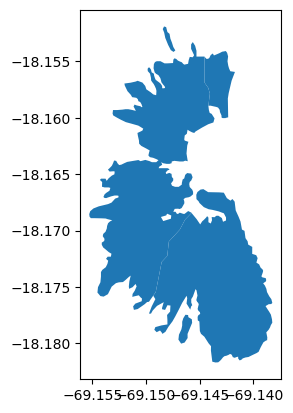

In [91]:
resultado.plot()

<Axes: >

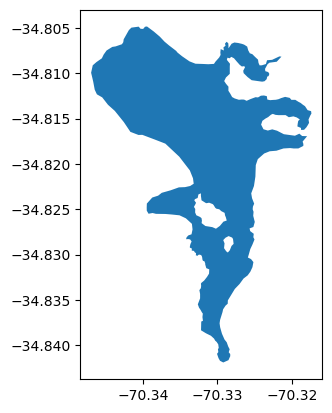

In [92]:
resultado1.plot()

<Axes: >

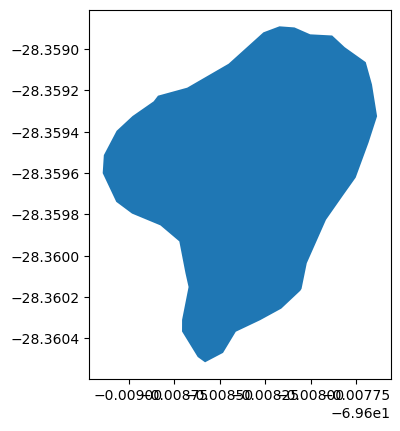

In [93]:
analisis.plot()

### Calculo del area del glaciar

In [94]:
aoi_observacion = aoi.buffer(100)

In [95]:
Map1 = geemap.Map(center=[y[0], x[0]], zoom=12)

# Iterar sobre las llaves del diccionario y agregar la primera imagen de cada lista al mapa
for year, image_list in area_visual.items():
    first_image = image_list[0]
    second_image = image_list[1]
    third_image = image_list[2]
    
    # Map.addLayer(first_image, {'bands': ['glacierPAN'w], 'min': 0, 'max': 1, 'palette': ['blue', 'white', 'green']}, f'{year} PAN Image')
    # Map.addLayer(second_image, {'bands': ['glacierRED'], 'min': 0, 'max': 1, 'palette': ['blue', 'white', 'green']}, f'{year} RED Image')
    Map1.addLayer(third_image.clip(aoi_observacion), {'bands': ['glacierPAN'], 'min': 0.4, 'max': 1, 'palette': ['blue', 'white', 'green']}, f'{year} PAN_threshold Image')
    # Map.addLayer(visual[year][1], {}, f'{year} Brightness Image')


Map1.add_layer(ee_multipolygon, {}, 'glaciar')
Map1

Map(center=[-28.364056553147115, -69.6095871859815], controls=(WidgetControl(options=['position', 'transparent…

### Datos "LANDSAT/LC08/C02/T1"

In [96]:
data_verano = [(f'{a}-12-01', f'{a+1}-03-31') for a in range(2013, 2024)]

In [97]:
def extract_images_for_year_landsatT1_verano(extract, aoi_glaciar):

    dataset_dict = {}
    
    for pos in range(len(extract)):
        dataset = ee.ImageCollection("LANDSAT/LC08/C02/T1").filterDate(extract[pos][0], extract[pos][1]).filter(ee.Filter.lt('CLOUD_COVER', 10)).filterBounds(aoi_glaciar)
        dataset = dataset.map(calculate_ndsi_pure)
        dataset = dataset.map(calculate_ndvi)
        dataset = dataset.map(calculate_ndwi_pure)
        dataset = dataset.map(add_band_B8_B6)
        
        
        dataset_dict[extract[pos][1][:4]] = dataset
 
    return dataset_dict

def make_visual_verano(collection_years, aoi_glaciar, extract):

    views_dict = {}

    for pos in range(len(extract)):
        views = []

        collection = collection_years[extract[pos][1][:4]]

        image_f = collection.first().clip(aoi_glaciar)
        
        image = collection.median().clip(aoi_glaciar)

        toa_reflectance = calculate_toa_reflectance(image, image_f)
        brightness_temp = calculate_brightness_temperature(image)
        image_with_ndsi = calculate_ndsi(toa_reflectance)
        image_with_ndvi = calculate_ndvi(image_with_ndsi)
        image_with_ndgi = calculate_ndgi(toa_reflectance)
        image_with_ndwi = calculate_ndwi(toa_reflectance)

        views.append(toa_reflectance)
        views.append(brightness_temp)
        views.append(image_with_ndsi)
        views.append(image_with_ndvi)
        views.append(image_with_ndgi)
        views.append(image_with_ndwi)
        
        
        views_dict[extract[pos][1][:4]] = views

    return views_dict
    

In [98]:
collection_years_verano = extract_images_for_year_landsatT1_verano(data_verano, aoi_glaciar)
visual_verano = make_visual_verano(collection_years_verano, aoi_glaciar, data_verano)


### Calculamos el filtro de las bandas de deteccion de nieve para el tiempo de verano en LANDSAT 8.

In [99]:
def calculate_ndpan_verano(collection_years, extract):
    views_dict = {}

    for pos in range(len(extract)):
        views = []

        collection = collection_years[extract[pos][1][:4]]

        image = collection.median().clip(aoi_glaciar)

        diferencepan = image.normalizedDifference(['B8', 'B6']).rename('glacierPAN')
        diferencered = image.normalizedDifference(['B4', 'B6']).rename('glacierRED')
        diferenceNDSI = image.normalizedDifference(['B3', 'B6']).rename('glacierNDSI')

        mask_pan = diferencepan.gte(0.4)
        mask_red = diferencered.gte(0.4)
        mask_NDSI = diferenceNDSI.gte(0.4)
        
        views.append(diferencepan)
        views.append(diferencered)

        diferencepan_filter = diferencepan.updateMask(mask_pan)
        diferencered_filter = diferencered.updateMask(mask_red)
        diferenceNDSI_filter = diferenceNDSI.updateMask(mask_NDSI)
        
        views.append(diferencepan_filter)
        views.append(diferencered_filter)
        views.append(diferenceNDSI_filter)
        
        views_dict[extract[pos][1][:4]] = views

    return views_dict
    
    

In [100]:
area_glaciar_verano = calculate_ndpan_verano(collection_years_verano, data_verano)

In [101]:
Verano = geemap.Map(center=[y[0], x[0]], zoom=12)

for year, image_list in area_glaciar_verano.items():
    
    third_image = image_list[2]
    
    Verano.addLayer(third_image.clip(aoi_observacion), {'bands': ['glacierPAN'], 'min': 0.4, 'max': 1, 'palette': ['blue', 'white', 'green']}, f'{year} PAN_threshold Image')

Verano.add_layer(ee_multipolygon, {}, 'glaciar')
Verano

Map(center=[-28.364056553147115, -69.6095871859815], controls=(WidgetControl(options=['position', 'transparent…

### Calculo del area de landsat 8 para las imagenes de verano

In [102]:
area_calculado = {}

for pos in range(len(data_verano)):
    pixel_area = ee.Image.pixelArea()
    
    # Multiplicar el área del píxel por la máscara de la imagen para obtener el área de interés
    masked_area_pan = pixel_area.updateMask(area_glaciar_verano[data_verano[pos][1][:4]][2])
    masked_area_red = pixel_area.updateMask(area_glaciar_verano[data_verano[pos][1][:4]][3])
    masked_area_NDSI = pixel_area.updateMask(area_glaciar_verano[data_verano[pos][1][:4]][4])
    
    # Reducir la imagen para obtener la suma total del área
    area_reduction_pan = masked_area_pan.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=area_glaciar_verano[data_verano[pos][1][:4]][2].geometry(),
        scale=7.5,  # Tamaño del píxel en la misma unidad que la imagen, en este caso 1x1
        maxPixels=1e10
    )

    area_reduction_red = masked_area_red.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=area_glaciar_verano[data_verano[pos][1][:4]][3].geometry(),
        scale=30,  # Tamaño del píxel en la misma unidad que la imagen, en este caso 1x1
        maxPixels=1e10
    )

    area_reduction_NDSI = masked_area_NDSI.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=area_glaciar_verano[data_verano[pos][1][:4]][4].geometry(),
        scale=30,  # Tamaño del píxel en la misma unidad que la imagen, en este caso 1x1
        maxPixels=1e10
    )
    
    # Obtener el área total
    total_area_pan = area_reduction_pan.getInfo()['area']
    total_area_red = area_reduction_red.getInfo()['area']
    total_area_NDSI = area_reduction_NDSI.getInfo()['area']
    area_calculado[data_verano[pos][1][:4]] = [total_area_pan / 10**6, total_area_red / 10**6, total_area_NDSI / 10**6]
    


### Datos "LANDSAT/LE07/C02/T1"

In [103]:
data_verano_l7 = [(f'{a}-12-01', f'{a+1}-03-31') for a in range(1999, 2013)]

In [104]:
def extract_images_for_year_landsat7T1_verano(extract, aoi_glaciar):

    dataset_dict = {}
    
    for pos in range(len(extract)):
        dataset = ee.ImageCollection("LANDSAT/LE07/C02/T1").filterDate(extract[pos][0], extract[pos][1]).filter(ee.Filter.lt('CLOUD_COVER', 10)).filterBounds(aoi_glaciar)
        dataset_dict[extract[pos][1][:4]] = dataset
 
    return dataset_dict

def make_visual_verano_L7(collection_years, aoi_glaciar, extract):

    views_dict = {}

    for pos in range(len(extract)):
        views = []

        collection = collection_years[extract[pos][1][:4]]

        image_f = collection.first().clip(aoi_glaciar)
        
        image = collection.median().clip(aoi_glaciar)

        views_dict[extract[pos][1][:4]] = views

    return views_dict 

In [105]:
collection_years_verano_l7 = extract_images_for_year_landsat7T1_verano(data_verano_l7, aoi_glaciar)
visual_verano_l7 = make_visual_verano_L7(collection_years_verano_l7, aoi_glaciar, data_verano_l7)


### Calculamos el filtro de las bandas de deteccion de nieve para el tiempo de verano en LANDSAT 7.

In [106]:
def calculate_ndpan_verano_l7(collection_years, extract):
    views_dict = {}

    for pos in range(len(extract)):
        views = []

        collection = collection_years[extract[pos][1][:4]]

        image = collection.median().clip(aoi_glaciar)

        
        diferencepan = image.normalizedDifference(['B8', 'B5']).rename('glacierPAN')
        diferencered = image.normalizedDifference(['B3', 'B5']).rename('glacierRED')
        diferenceNDSI = image.normalizedDifference(['B2', 'B5']).rename('glacierNDSI')

        mask_pan = diferencepan.gte(0.4)
        mask_red = diferencered.gte(0.4)
        mask_NDSI = diferenceNDSI.gte(0.4)
        
        views.append(diferencepan)
        views.append(diferencered)


        diferencepan_filter = diferencepan.updateMask(mask_pan)
        diferencered_filter = diferencered.updateMask(mask_red)
        diferenceNDSI_filter = diferenceNDSI.updateMask(mask_NDSI)
        
        views.append(diferencepan_filter)
        views.append(diferencered_filter)
        views.append(diferenceNDSI_filter)
        
        views_dict[extract[pos][1][:4]] = views

    return views_dict
    
    

In [107]:
area_glaciar_verano_l7 = calculate_ndpan_verano_l7(collection_years_verano_l7, data_verano_l7)

In [108]:
for year, image_list in area_glaciar_verano_l7.items():
    third_image = image_list[2]

    Verano.addLayer(third_image.clip(aoi_observacion), {'bands': ['glacierPAN'], 'min': 0.4, 'max': 1, 'palette': ['blue', 'white', 'green']}, f'{year} PAN_threshold Image')

Verano.add_layer(ee_multipolygon, {}, 'glaciar')
Verano

Map(center=[-28.364056553147115, -69.6095871859815], controls=(WidgetControl(options=['position', 'transparent…

### Calculo del area de landsat 7 para las imagenes de verano

In [109]:
for pos in range(len(data_verano_l7)):
    pixel_area = ee.Image.pixelArea()
    
    # Multiplicar el área del píxel por la máscara de la imagen para obtener el área de interés
    masked_area_pan = pixel_area.updateMask(area_glaciar_verano_l7[data_verano_l7[pos][1][:4]][2])
    masked_area_red = pixel_area.updateMask(area_glaciar_verano_l7[data_verano_l7[pos][1][:4]][3])
    masked_area_NDSI = pixel_area.updateMask(area_glaciar_verano_l7[data_verano_l7[pos][1][:4]][4])
    
    
    # Reducir la imagen para obtener la suma total del área
    area_reduction_pan = masked_area_pan.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=area_glaciar_verano_l7[data_verano_l7[pos][1][:4]][2].geometry(),
        scale=7.5,  # Tamaño del píxel en la misma unidad que la imagen, en este caso 1x1
        maxPixels=1e10
    )

    area_reduction_red = masked_area_red.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=area_glaciar_verano_l7[data_verano_l7[pos][1][:4]][3].geometry(),
        scale=30,  # Tamaño del píxel en la misma unidad que la imagen, en este caso 1x1
        maxPixels=1e10
    )

    area_reduction_NDSI = masked_area_NDSI.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=area_glaciar_verano_l7[data_verano_l7[pos][1][:4]][4].geometry(),
        scale=30,  # Tamaño del píxel en la misma unidad que la imagen, en este caso 1x1
        maxPixels=1e10
    )
    
    # Obtener el área total
    total_area_pan = area_reduction_pan.getInfo()['area']
    total_area_red = area_reduction_red.getInfo()['area']
    total_area_NDSI = area_reduction_NDSI.getInfo()['area']
    area_calculado[data_verano_l7[pos][1][:4]] = [total_area_pan / 10**6, total_area_red / 10**6, total_area_NDSI / 10**6]


### Gif cambio del glaciar

In [110]:
nombres_bandas = ['glacierPAN', 'glacierRED', 'glacierNDSI']

In [111]:
import requests

for band in range(2, 5):
    images_to_collection = []
    for year in range(2000, 2025):
        if year <= 2013:
            images_to_collection.append(area_glaciar_verano_l7[str(year)][band])
        else:
            images_to_collection.append(area_glaciar_verano[str(year)][band])
    
    gif_glaciar = ee.ImageCollection(images_to_collection)
    
    videoArgs = {
        'dimensions': 768,
        'region': ee_multipolygon,
        'framesPerSecond': 1,
        'bands': nombres_bandas[band - 2],
        'crs': 'EPSG:4326',
        'min': 0.4,
        'max': 1,
        'palette': ['blue', 'white', 'green']
    }
    
    video_url = gif_glaciar.getVideoThumbURL(videoArgs)
    print(f"Video URL for band {band}: {video_url}")
    
    # Descargar el GIF
    response = requests.get(video_url)
    
    if response.status_code == 200:
        with open(f'glaciar_band_{band}.gif', 'wb') as f:
            f.write(response.content)
        print(f'GIF for band {band} has been downloaded successfully.')
    else:
        print(f'Failed to download GIF for band {band}. HTTP status code: {response.status_code}')


Video URL for band 2: https://earthengine.googleapis.com/v1/projects/earthengine-legacy/videoThumbnails/21b19edad062861e54ec2d99d78625bb-25fe0c7a41ac134cf45192b1a89b0abc:getPixels
GIF for band 2 has been downloaded successfully.
Video URL for band 3: https://earthengine.googleapis.com/v1/projects/earthengine-legacy/videoThumbnails/10a8dab083cbfa4845011ea648fc0166-26475f18616db7569b313689d1a75a30:getPixels
GIF for band 3 has been downloaded successfully.
Video URL for band 4: https://earthengine.googleapis.com/v1/projects/earthengine-legacy/videoThumbnails/a8cc257db227aba97ac6c12397a8bb94-f5a83c08b8c8067aba2b5eec56570edd:getPixels
GIF for band 4 has been downloaded successfully.


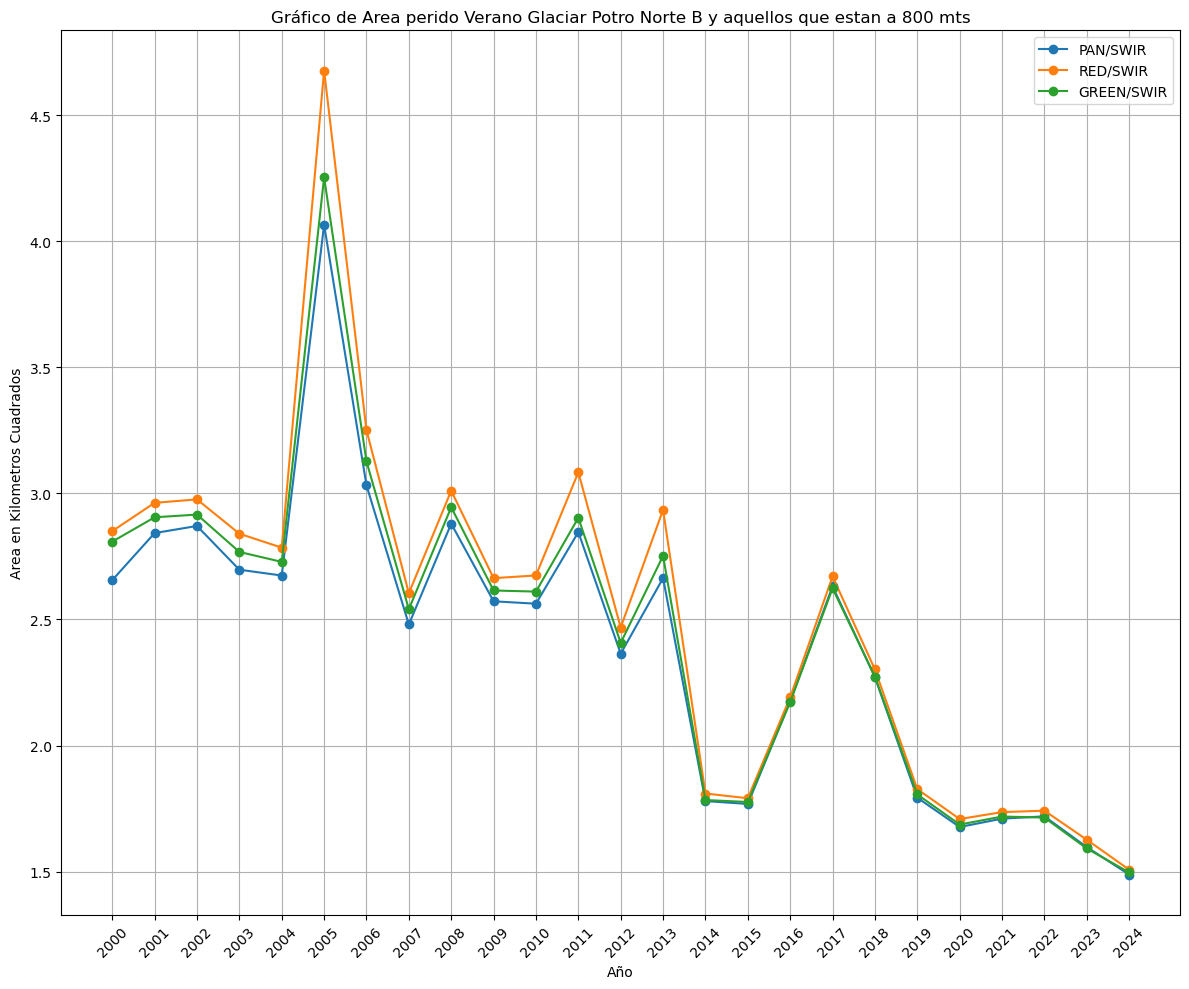

In [112]:
valores_verano_pan = []
valores_verano_red = []
valores_verano_NDSI = []
anios_verano = list(range(2000, 2025)) 
for year in range(2000, 2025):
    valores_verano_pan.append(area_calculado[str(year)][0])
    valores_verano_red.append(area_calculado[str(year)][1])
    valores_verano_NDSI.append(area_calculado[str(year)][2])
    
fig , ax = plt.subplots(figsize = (12, 10))
ax.plot(anios_verano, valores_verano_pan, marker='o', label = 'PAN/SWIR')
ax.plot(anios_verano, valores_verano_red, marker='o', label = 'RED/SWIR')
ax.plot(anios_verano, valores_verano_NDSI, marker='o', label = 'GREEN/SWIR')

plt.legend()
plt.xlabel('Año')
plt.ylabel('Area en Kilometros Cuadrados')
plt.title('Gráfico de Area perido Verano Glaciar Potro Norte B y aquellos que estan a 800 mts')


plt.grid(True)
plt.xticks(range(2000, 2025, 1)) 
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()

### Analisis area del modelo

In [113]:
import json

polygon_geojson = aoi_observacion.getInfo()

with open('polygon.geojson', 'w') as f:
    json.dump(polygon_geojson, f)

# Cargar el GeoJSON en un GeoDataFrame
gdf_poligono = gpd.read_file('polygon.geojson')

In [114]:
poligono_observar = gdf_poligono.to_crs(4326).iloc[0].geometry


In [115]:
area_forest_tree_class = {}

for year, dtf in final_result['3'].items():
    area_est = final_result['3'][year][(final_result['3'][year].intersects(poligono_observar) == True) & (final_result['3'][year]['class_pred'] == 1)].to_crs(32719).geometry.area
    area_forest_tree_class[str(int(year) + 1)] = area_est.sum() / 10**6

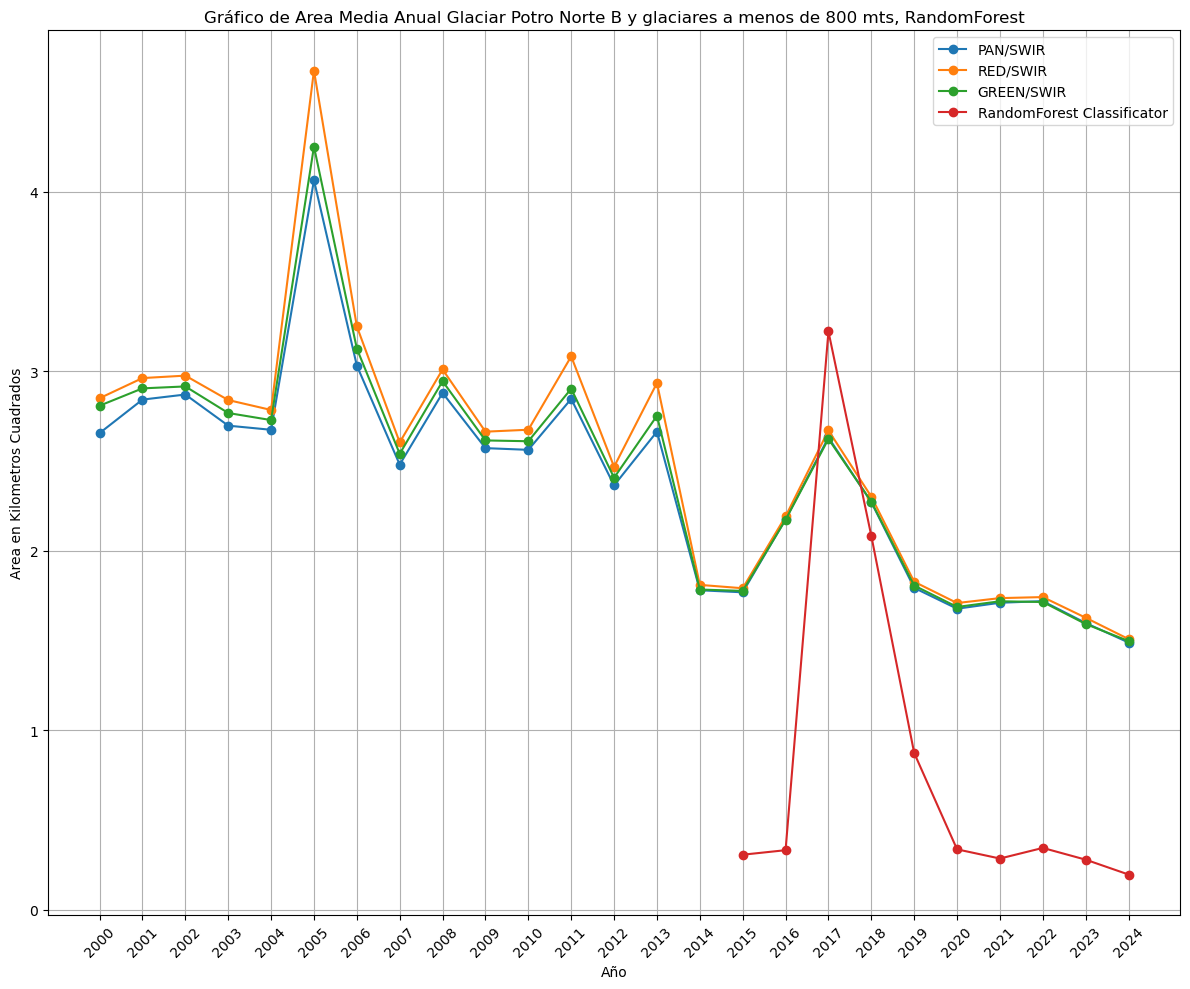

In [116]:
valores = []
anios = list(range(2015, 2025)) 
for year in range(2015, 2025):
    valores.append(area_forest_tree_class[str(year)])
    
fig , ax = plt.subplots(figsize = (12, 10))
ax.plot(anios_verano, valores_verano_pan, marker='o', label = 'PAN/SWIR')
ax.plot(anios_verano, valores_verano_red, marker='o', label = 'RED/SWIR')
ax.plot(anios_verano, valores_verano_NDSI, marker='o', label = 'GREEN/SWIR')
ax.plot(anios, valores, marker='o', label='RandomForest Classificator')

ax.legend()
plt.xlabel('Año')
plt.ylabel('Area en Kilometros Cuadrados')
plt.title('Gráfico de Area Media Anual Glaciar Potro Norte B y glaciares a menos de 800 mts, RandomForest')


plt.grid(True)
plt.xticks(range(2000, 2025, 1)) 
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()